<a href="https://colab.research.google.com/github/ukab23/-Simple-Linear-Regression/blob/master/cdqa2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd

In [22]:
from google.colab import files
uploaded = files.upload()

Saving articles1.csv to articles1.csv


In [0]:
import io
data = pd.read_csv(io.BytesIO(uploaded['articles1.csv']))
data = data.iloc[:5000,:]

In [0]:
import os
from ast import literal_eval
from cdqa.utils.filters import filter_paragraphs
from cdqa.pipeline.cdqa_sklearn import QAPipeline 

In [57]:
from cdqa.utils.download import download_model
download_model(model='bert-squad_1.1', dir='./models')


bert_qa_vCPU-sklearn.joblib already downloaded


In [0]:
stp_wrd = []

In [0]:
punctuations = '"#$%&\'()*+,-/:;<=>@[\\]^_`{|}~—”“'

In [0]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def process_text(text):
    nopunc = [char for char in text if char not in punctuations]
    nopunc = ''.join(nopunc)
    clean_words = [word.lower() for word in nopunc.split() if word.lower() not in stp_wrd]
    clean_words = [lemmatizer.lemmatize(lem) for lem in clean_words]
    clean_words = " ".join(clean_words)
    return clean_words

In [31]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
data['content'] = data['content'].apply(process_text)

In [0]:
def text_list(text):
    text = text.split('. ')
    return text

In [0]:
data['paragraphs'] = data['content'].apply(text_list)
data.to_csv('content1.csv')

In [64]:
df = pd.read_csv('content1.csv', converters={'paragraphs': literal_eval})
df = filter_paragraphs(df)
df.head()

,Unnamed: 0,Unnamed: 0.1,id,title,publication,author,date,year,month,url,content,paragraphs
0,0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,washington congressional republican have a new...,[eager to avoid an ugly political pileup repub...
1,1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,after the bullet shell get counted the blood d...,[gola white who wa beside her daughter when sh...
2,2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,when walt disney’s bambi opened in 1942 critic...,[the question came like gunfire in which direc...
3,3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,death may be the great equalizer but it isn’t ...,[he had hinted that his time wa short in the l...
4,4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,seoul south korea north korea’s leader kim sai...,[after the north’s satellite launch in februar...


In [0]:
df = df[['title','paragraphs','content']]

In [0]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [0]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(df.content)
text = tfidf.transform(df.content)

In [0]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters


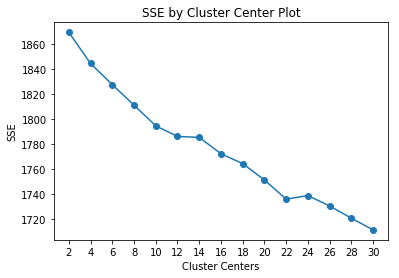

In [73]:
find_optimal_clusters(text, 30)

In [89]:
text

<2021x8000 sparse matrix of type '<class 'numpy.float64'>'
	with 714796 stored elements in Compressed Sparse Row format>

In [0]:
clusters = MiniBatchKMeans(n_clusters=12, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

In [0]:
import numpy as np
import matplotlib.cm as cm
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=True)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

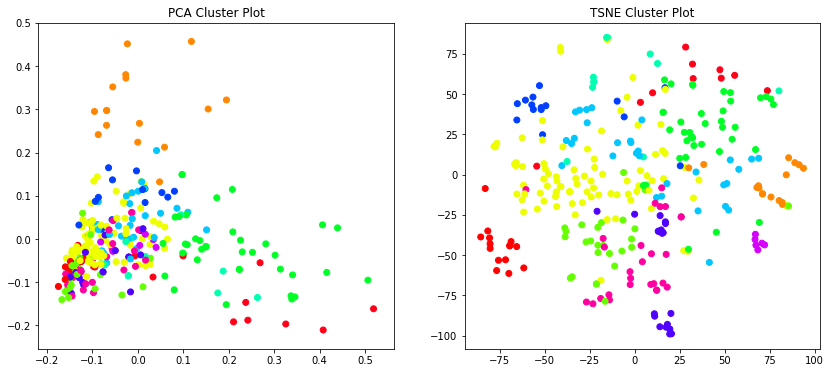

In [84]:
plot_tsne_pca(text, clusters)

In [0]:
df['class'] = pd.Series(clusters, index=df.index)

In [87]:
df.head(5)

,title,paragraphs,content,class
0,House Republicans Fret About Winning Their Hea...,[eager to avoid an ugly political pileup repub...,washington congressional republican have a new...,11
1,Rift Between Officers and Residents as Killing...,[gola white who wa beside her daughter when sh...,after the bullet shell get counted the blood d...,7
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",[the question came like gunfire in which direc...,when walt disney’s bambi opened in 1942 critic...,8
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",[he had hinted that his time wa short in the l...,death may be the great equalizer but it isn’t ...,10
4,Kim Jong-un Says North Korea Is Preparing to T...,[after the north’s satellite launch in februar...,seoul south korea north korea’s leader kim sai...,6


In [0]:
df2 = df[df['class'] == 1]

In [145]:
df2 = df2.reset_index()
df2 = df2[['title','content','paragraphs','class']]
df2.head()

,title,content,paragraphs,class
0,"Damaged by War, Syria’s Cultural Sites Rise An...",paris when the islamic state wa about to be dr...,[expert from many country are trying to ass th...,1
1,ISIS Claims Responsibility for Istanbul Nightc...,istanbul the islamic state on monday issued a ...,[istanbul the islamic state on monday issued a...,1
2,The Afghan War and the Evolution of Obama - Th...,washington president obama’s adviser wrestled ...,[obama meant wa that no one in the situation r...,1
3,"In Turkey, U.S. Hand Is Seen in Nearly Every C...",istanbul turkish official accused the united s...,[rather than bringing the united state and tur...,1
4,A New Casualty of Syria’s War: Drinking Water ...,beirut lebanon for million of damascus residen...,[while a brokered by russia and turkey and ann...,1


In [168]:
df2['content'][57]

'the operative belonged to an intelligence unit of the islamic state known in arabic a the emni which ha become a combination of an internal police force and an external operation branch dedicated to exporting terror abroad according to thousand of page of french belgian german and austrian intelligence and interrogation document obtained by the times reinforcing the idea that the emni is a core part of the islamic state’s operation the interview and document indicate that the unit ha carte blanche to recruit and reroute operative from all part of the organization from new arrival to seasoned battlefield fighter and from the group’s special force and it elite commando units he said he wa told that undercover operative in europe used new convert a or clean men who help link up people interested in carrying out attack with operative who can pas on instruction on everything from how to make a suicide vest to how to credit their violence to the islamic state it’s the emni that ensures the 

In [0]:
import psutil, os

def memory_footprint():
	mem = psutil.Process(os.getpid()).memory_info().rss
	return (mem/1024**2)

In [0]:
before = memory_footprint()

In [149]:
cdqa_pipeline = QAPipeline(reader='./models/bert_qa_vCPU-sklearn.joblib')
cdqa_pipeline.fit_retriever(X=df2)

QAPipeline(reader=BertQA(bert_model='bert-base-uncased', do_lower_case=True,
                         fp16=False, gradient_accumulation_steps=1,
                         learning_rate=3e-05, local_rank=-1, loss_scale=0,
                         max_answer_length=30, n_best_size=20, no_cuda=False,
                         null_score_diff_threshold=0.0, num_train_epochs=2,
                         output_dir='models', predict_batch_size=8, seed=42,
                         server_ip='', server_port='', train_batch_size=8,
                         verbose_logging=False, version_2_with_negative=False,
                         warmup_proportion=0.1))

In [0]:
after = memory_footprint()

In [100]:
[before,after]

[7037.84765625, 7283.0390625]

In [0]:
df2 = df[['title','paragraphs']]

In [166]:
query = 'What did saudi arabia has told the obama administration?'
prediction = cdqa_pipeline.predict(X=query)

3it [00:00, 1600.07it/s]


In [154]:
prediction

('the islamic state',
 'ISIS Claims Responsibility for Istanbul Nightclub Attack - The New York Times',
 'istanbul the islamic state on monday issued a rare claim of responsibility for an attack in turkey after a new year’s day shooting at an istanbul nightclub that killed at least 39 people describing the gunman who carried out the assault and who ha not been identified or captured a a hero soldier of the caliphate')

In [167]:
print('query: {}'.format(query))
print('answer: {}'.format(prediction[0]))
print('title: {}'.format(prediction[1]))
print('paragraph: {}\n'.format(prediction[2]))

query: What did saudi arabia has told the obama administration?
answer: it will sell off hundred of billion of dollars’ worth of american asset held by the kingdom
title: Saudi Arabia Warns of Economic Fallout if Congress Passes 9/11 Bill - The New York Times
paragraph: washington saudi arabia ha told the obama administration and member of congress that it will sell off hundred of billion of dollars’ worth of american asset held by the kingdom if congress pass a bill that would allow the saudi government to be held responsible in american court for any role in the sept



In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [45]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
data = data.iloc[:5000,:]